# EP2 - Modelando o SARS-CoV-2

Hello, little fellows.

In [30]:
import math                          # exp(), ...
import matplotlib.pyplot as pyplot   # plot(), ...

Neste EP você vai simular o modelo dinâmico do COVID-19 resolvendo numericamente, por
Euler, a eq. 4 para algumas situações diferentes ligadas aos parâmetros $\alpha, \lambda,$ A e $t_0$.

$\frac{dN}{dt} = \alpha \bigg(1 - \frac{N}{\eta t^2} \bigg)N - \bigg(\frac{2\lambda t^2 - 1}{t} - \frac{\lambda (t_0)^2}{t} e^{-\lambda (t-t_0)^2}\bigg)N$

sendo $\alpha > 0$ o fator de crescimento, $t_0$ o tempo inicial que depende de medidas de restrição, $\lambda = \sigma^{-1}$ e $\eta = 2A/t_0$, onde A é um parâmetro que depende do vírus e das medidas de restrição.

1. Assumindo que estamos numa ilha isolada, simule a evolução de N para um conjunto {$\alpha, \lambda$, A, $t_0$}. Nesse caso, o vetor de estados é unidimensional v(t) = \[N\](t). Faça um gráfico bonito para mostrar a evolução de v em relação a t, i.e. v(t). Faça também uma simulação dinâmica usando os recursos explicados em aula.

Dado o enunciado, a função que nos interessa recebe como parâmetros {$\alpha, \lambda, t_0, A$}. Sua evolução deve ser modelada a partir do método de Euler, por meio do qual se realiza uma aproximação da equação diferencial a partir de diferenças finitas:

$$\frac{dN}{dt} =  \frac{N_{t+1} - N_{t}}{dt} \rightarrow N_{t+1} = N_t + \bigg[\alpha \bigg(1 - \frac{N}{\eta t^2} \bigg)N - \bigg(\frac{2\lambda t^2 - 1}{t} - \frac{\lambda (t_0)^2}{t} e^{-\lambda (t-t_0)^2}\bigg)N \bigg]dt $$

seja $N = N_t$, temos

$$N_{t+1} = N_t + \bigg[\alpha \bigg(1 - \frac{N_t}{\eta t^2} \bigg)N_t - \bigg(\frac{2\lambda t^2 - 1}{t} - \frac{\lambda (t_0)^2}{t} e^{-\lambda (t-t_0)^2}\bigg)N_t \bigg]dt $$


In [47]:
# N é o número de pessoas infectadas num certo tempo t

def nextN(N_0, dt, alfa, lamb, t0, A, t):
    eta = (2*A)/t0
    #print(eta)
    
    N  = alfa*(1-N_0/(eta*t**2))
    aux = ((2*lamb*t**2 -1)-(lamb*t0**2)*(math.exp(-lamb*(t-t0)**2)))/t
    #print(aux)
    N -= aux
    N *= N_0
    
    # Euler
    N *= dt
    N += N_0
    
    return N

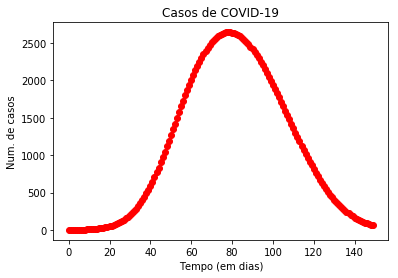

[1, 1, 1, 2, 2, 3, 3, 4, 5, 7, 8, 10, 12, 15, 18, 21, 25, 30, 35, 41, 48, 56, 66, 76, 88, 102, 117, 134, 154, 175, 199, 225, 254, 285, 320, 357, 398, 442, 489, 539, 592, 648, 708, 770, 835, 903, 973, 1044, 1118, 1193, 1269, 1345, 1422, 1499, 1576, 1652, 1727, 1800, 1872, 1942, 2009, 2074, 2136, 2195, 2251, 2303, 2352, 2398, 2439, 2477, 2512, 2542, 2568, 2591, 2609, 2624, 2635, 2642, 2645, 2645, 2641, 2633, 2622, 2607, 2589, 2568, 2544, 2517, 2487, 2453, 2418, 2380, 2339, 2296, 2251, 2204, 2155, 2104, 2052, 1999, 1944, 1888, 1831, 1773, 1715, 1656, 1597, 1538, 1478, 1419, 1360, 1302, 1244, 1186, 1130, 1074, 1020, 966, 914, 863, 813, 765, 719, 674, 630, 589, 549, 510, 474, 439, 406, 375, 345, 317, 291, 266, 243, 222, 202, 183, 166, 150, 135, 122, 109, 98, 87, 78, 69, 61]


In [60]:
def main():
    # Alguns dos dados abaixo foram retirados do 
    # documento do Sonino para o caso da Itália (p. 12)
    # https://arxiv.org/pdf/2003.13540v5.pdf
    
    # A maioria é aleatória tho
    N_0 = 1 #165155 - número de casos em t0
    dt = 1 # passo = 1 dia
    alfa = 0.2
    lamb = 0.001 #0.0014
    t0 = 10 #70.6 - tempo inicial
    A = 10 #302.5 
    t = t0
    N = N_0
    v = []
    t_f = 160
    
    while(t < t_f and N >= 0):
        v.append(int(N))
        t += dt
        N = nextN(N, dt, alfa, lamb, t0, A, t)

    pyplot.figure()
    pyplot.plot(v,linestyle='',marker='o',color='r')
    pyplot.title('Casos de COVID-19')
    pyplot.ylabel('Num. de casos')
    pyplot.xlabel('Tempo (em dias)')
    pyplot.show()
    
    print(v)
    

main()